<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Загрузка-библиотек-и-анализ-данных" data-toc-modified-id="Загрузка-библиотек-и-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка библиотек и анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Предобработка-и-разбиение-данных" data-toc-modified-id="Предобработка-и-разбиение-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка и разбиение данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Построение-моделей" data-toc-modified-id="Построение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Построение моделей</a></span><ul class="toc-item"><li><span><a href="#Pipeline-обучения-основных-моделей-с-подбором-гиперпараметров" data-toc-modified-id="Pipeline-обучения-основных-моделей-с-подбором-гиперпараметров-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Pipeline обучения основных моделей с подбором гиперпараметров</a></span></li><li><span><a href="#Dummy-модель" data-toc-modified-id="Dummy-модель-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Dummy модель</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

### Описание проекта

Дано: Набор данных пользовательских комментариев интернет-магазина с разметкой о токсичности правок.

Цель: Классификация комментариев на позитивные и негативные.

Base-line: Значение метрики F1 на тестовой выборке > 0.75.

### Загрузка библиотек и анализ данных

In [1]:
import pandas as pd
import re
import nltk
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

import seaborn as sns
import timeit

# Игнорирование предупреждения об ошибках
import warnings
warnings.filterwarnings('ignore')

# Настройки для печати нескольких выводов данных в одной ячейке
from IPython.core.interactiveshell import InteractiveShell

In [2]:
# Считываем данные
df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
# Посмотрим общую информацию о наборе данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
# Посмотрим примеры токсичных отзывов
df[df['toxic']==1].head()

,text,toxic
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,"Bye! \n\nDon't look, come or think of comming ...",1
42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1


In [5]:
# Посмотрим примеры не токсичных отзывов
df[df['toxic']==0].head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


0    143346
1     16225
Name: toxic, dtype: int64


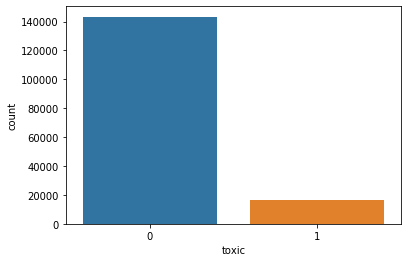

In [6]:
# Проверим балланс классов
print(df['toxic'].value_counts())
sns.countplot(df['toxic']);

#### Вывод

- В работе тексты на английском языке.  
- Выявлен критичный дисбалланс классов.   
- Требуется очистка данных от лишних символов и слов.  

### Предобработка и разбиение данных

In [7]:
# Подготовим символы и стоп-слова для удаления из текстов
patterns = "[!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_en = stopwords.words("english")
morph = MorphAnalyzer()

In [8]:
# Напишем функцию для лемматизации - приведения слов к начальной форме
def lemmatize(df_str):
    
    df_str = re.sub(patterns, ' ', df_str)
    tokens = []
    for token in df_str.split():
        if token and token not in stopwords_en:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    
    return tokens    

In [9]:
# Применим функцию лемматизации к текстам
df['text'] = df['text'].apply(lemmatize)

In [10]:
# Проверим получившийся результат
df.head()

,text,toxic
0,"[explanation, why, edits, made, username, hard...",0
1,"[d, aww, he, matches, background, colour, i, s...",0
2,"[hey, man, i, really, trying, edit, war, it, g...",0
3,"[more, i, make, real, suggestions, improvement...",0
4,"[you, sir, hero, any, chance, remember, page]",0


In [11]:
# Выделим целевой признак в отдельную переменную
target = df['toxic']
features = df['text'].astype('U')

In [12]:
# Поделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print('Размер обучающего набора данных: ', X_train.shape)
print('Размер тренировочного набора данных: ', X_test.shape)

Размер обучающего набора данных:  (127656,)
Размер тренировочного набора данных:  (31915,)


Ситуация по баллансу классов после уменьшения мажоритарного класса:
0    40136
1    12981
Name: toxic, dtype: int64


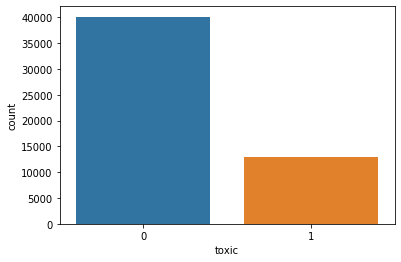

In [13]:
# Напишем функцию которая уменьшает объекты мажоритарного класса и перемешивает данные
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

# Применим функцию к данным
X_train, y_train = downsample(X_train, y_train, 0.35)

print('Ситуация по баллансу классов после уменьшения мажоритарного класса:')
print(y_train.value_counts())
sns.countplot(y_train);

#### Вывод

- Из текстов удалены лишние символы и стоп-слова.  
- Произведена лемматизация - приведение слов к начальной форме.
- Минимизирован дисбалланс классов путем уменьшения объектов мажоритарного класса. 

### Построение моделей

#### Pipeline обучения основных моделей с подбором гиперпараметров

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [15]:
# Сформируем пайплайн
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', LogisticRegression(random_state=12345))
])

params = [{
        'vect__ngram_range': ((1, 1), (1, 2)),
        'tfidf__use_idf': (True, False),
        'model': [LinearSVC(random_state=12345, class_weight='balanced')],
        'model__C': [10, 100]
    }, {
        'vect__ngram_range': ((1, 1), (1, 2)),
        'tfidf__use_idf': (True, False),
        'model': [LogisticRegression(random_state=12345, class_weight='balanced')],
        'model__C': [10, 100]
    }
]

In [16]:
# Запустим GridSearchCV
kf = KFold(n_splits=4, random_state=42)
grid = GridSearchCV(pipe, param_grid=params, scoring='f1', cv=kf, verbose=False)
grid = grid.fit(X_train, y_train)

In [17]:
# Посмотрим на лучшую модель
grid.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
                ('model',
                 LinearSVC(C=10, class_weight='balanced', dual=True,
                           fit_intercept=True, intercept_scaling=1,
             

In [18]:
# Сгруппируем результаты GridSearchCV в таблицу
grid_results = pd.DataFrame(grid.cv_results_)
models = ['LinearSVC', 'LogisticRegression']
cols = ['mean_fit_time', 'mean_score_time', 'mean_test_score']
res = pd.DataFrame(columns=cols)

for model in models:
    model_idx = grid_results['param_model'].astype('str').str.contains(model)
    best_fit = round(grid_results[model_idx].sort_values(by='rank_test_score').head(1)[cols], 2)
    res = res.append(best_fit)
    res.loc[best_fit.index, 'model'] = model
    
res.sort_values(by='mean_test_score', ascending=True)

,mean_fit_time,mean_score_time,mean_test_score,model
3,17.41,1.44,0.85,LinearSVC
13,31.04,1.53,0.85,LogisticRegression


In [19]:
# Проверим лучшую модель на тестовом наборе данных
model = grid.best_estimator_

y_pred = model.predict(X_test)
print('F1 на тестовом наборе данных:', round(f1_score(y_test, y_pred), 2))

F1 на тестовом наборе данных: 0.76


#### Dummy модель

In [20]:
model_dummy = DummyClassifier()
model_dummy.fit(X_train, y_train)
prediction_dummy = model_dummy.predict(X_test)
print('F1 для Dummy модели составил ', round(f1_score(y_test, prediction_dummy),2))

F1 для Dummy модели составил  0.15


### Вывод

- Реализован pipeline для подбора обработки данных и подбору модели с оптимальными гиперпараметрами. 
- Лучшая модель: LinearSVC
- Значение метрики F1 на тестовом наборе данных 0.76. 
- Модель адекватна, т.к. значение метрики 0.76 выше, чем у dummy модели.